In [1]:
import pandas as pd
import numpy as np

import graphviz
import pandas_profiling
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, precision_recall_fscore_support

%matplotlib inline

Columns:
* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
* target - 1 or 0

In [2]:
path = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", 
           "trestbps", "chol", "fbs", 
           "restecg", "thalach","exang", 
           "oldpeak","slope", "ca", "thal", "num"]

data_pd = pd.read_csv(path, header=None, names=columns, na_values=['?'])
data_pd['target'] = np.where(data_pd.num > 0, 1, 0)
data_pd.drop('num', inplace=True, axis=1)

In [3]:
pandas_profiling.ProfileReport(data_pd)

Number of variables,14
Number of observations,303
Total Missing (%),0.1%
Total size in memory,33.2 KiB
Average record size in memory,112.3 B
Numeric,10
Categorical,0
Boolean,4
Date,0
Text (Unique),0
Rejected,0


### Logistic Regression

Basic Training (train/test split)

Cross validation

Grid search

### Metrics

Accuracy

Precision and Recall

Confusion Matrix

Roc / Precision-Recall Curve

Regularization (L1, L2)

### Logistic Regression Interpretation

Coefficients

Visualization

### Decision Tree

Grid Search

Precision/Recall

### Decision Tree Interpretation

Feature importance

Visualization

Decision tree boundaries

In [ ]:
More advanced interpretation techniques

Understand the tradeoff:

Inspect the tree:

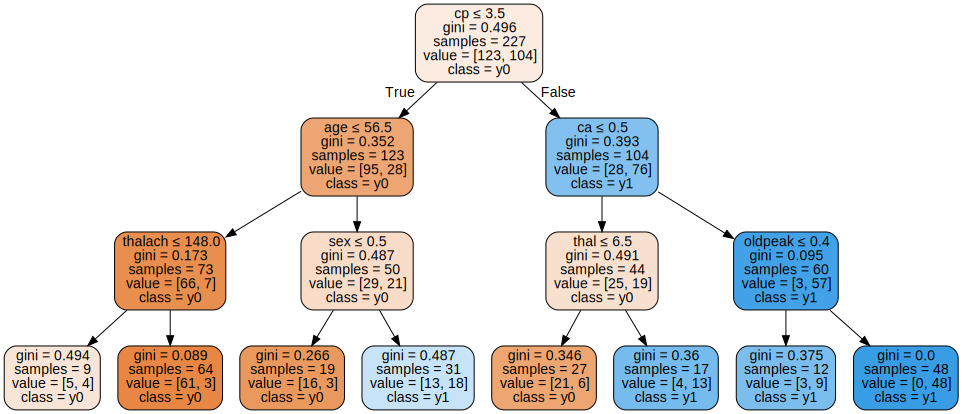

In [11]:
dot_data = tree.export_graphviz(grid_search.best_estimator_, out_file=None, 
                                feature_names=data_pd.columns[:-1],  
                                class_names=True,
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

Decision surface:

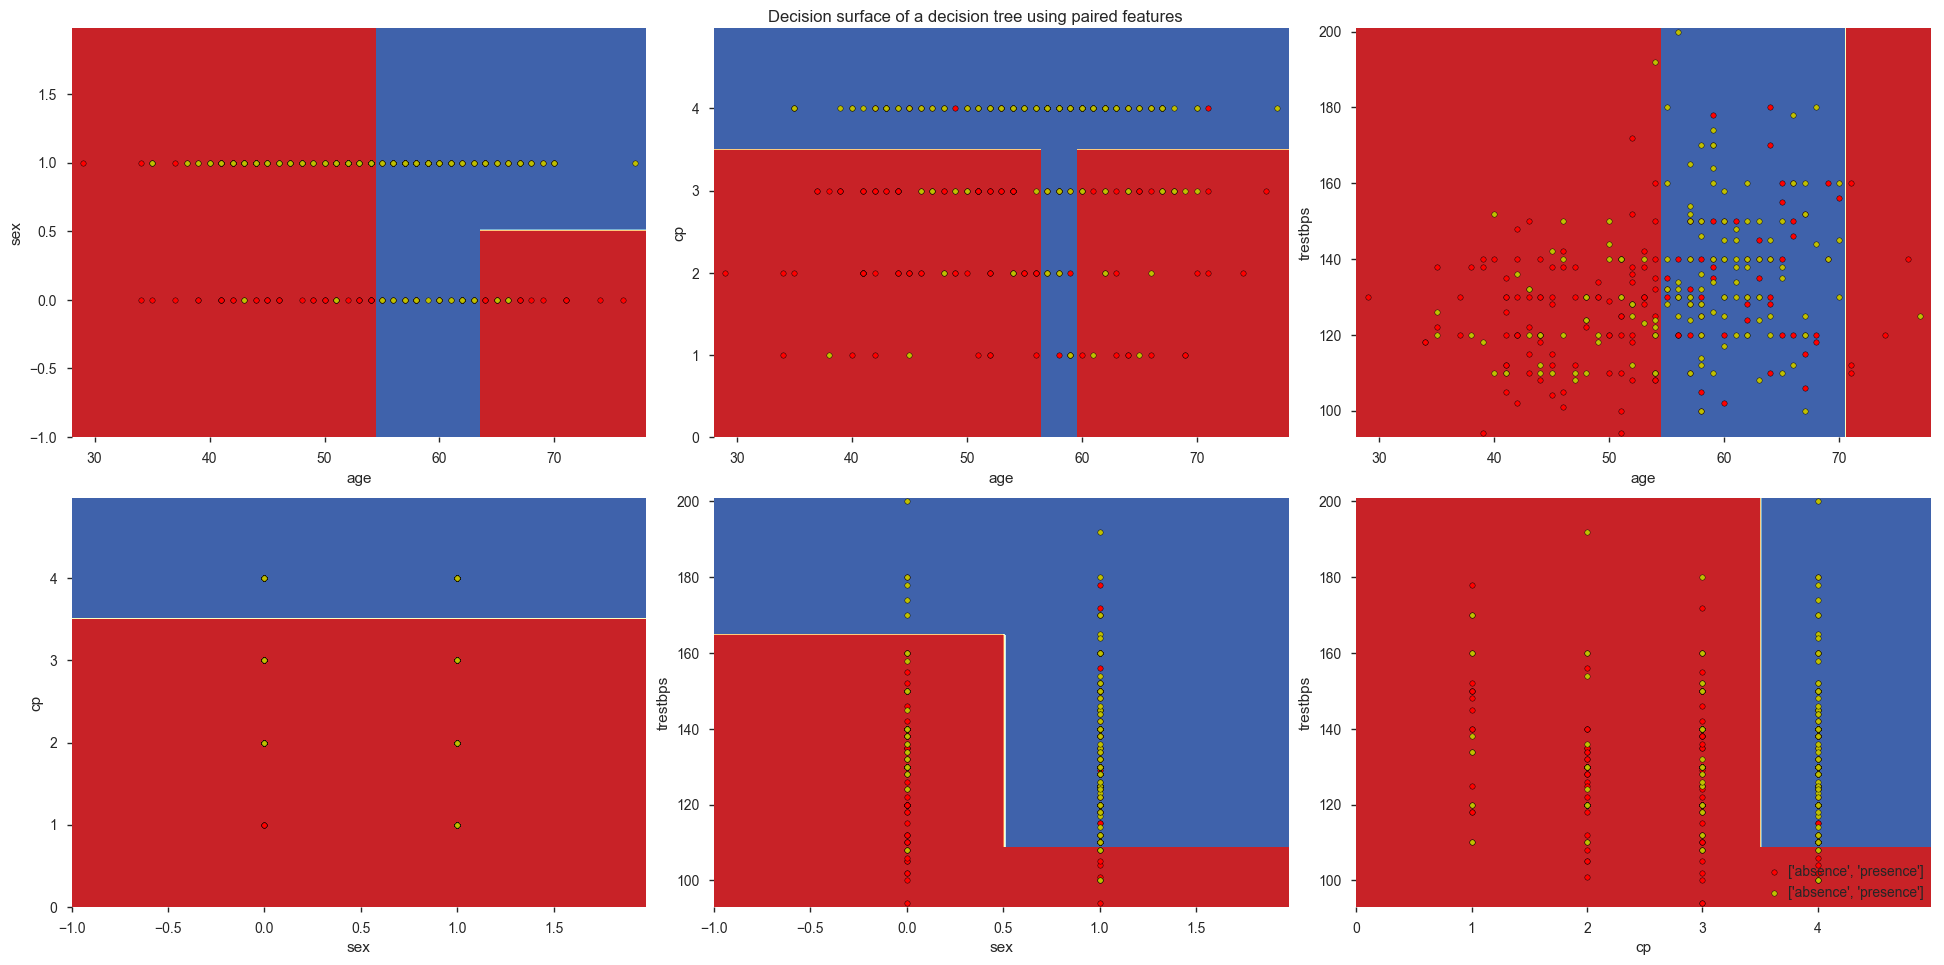

In [12]:
# Parameters
n_classes = 2
plot_colors = "ryb"
plot_step = 0.02

plt.figure(figsize=(20,10))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = data_pd[data_pd.columns[:-1]].values[:, pair]
    y = data_pd['target']

    # Train
    clf = tree.DecisionTreeClassifier(**grid_search.best_params_).fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(data_pd.columns[pair[0]])
    plt.ylabel(data_pd.columns[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=['absence', 'presence'],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

Undestand predictions: